# Simple MNIST NN from scratch

By Samson Zhang
Adapted by Juan Rojas
Oct, 2024.

---
This notebook implements a 2-layer neural network that is trained on the MNIST digit recognizer dataset.

Run from colab using this link:
https://colab.research.google.com/drive/15Shn0zfCZE7lTdb_vk5bZeaCYduetbPm?usp=sharing

Samson Zhang explains the code and math here: https://youtu.be/w8yWXqWQYmU

Check out a real-time implementation of the NN in which you can draw a number and look at the prediction: https://adamharley.com/nn_vis/cnn/3d.html

In [ ]:
# IMPORTANT:
# RUN THIS CELL IN ORDER TO IMPORT KAGGLE DATA SOURCES AIM IMPORT
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T031203Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3e243e7f4e56ce6c1990fc093451828afb085fb2717afb4168cf557d7db70a787188fe423c0cc5f8b5fbf8c0fa697693e107da813eb65d8d0e1ec2b5acc64f99c922680a6218cbbb605b9eed2ac4103051dad0efc3abf8af39983c7b44fa4eeaa8db8f08abeaa59cee99712b8c3015c7583b4ffa729ee403db7befa6f5da85de022671a6153eca0667b8a9fe46d33956d292426bb984b114b8599312da3d3119a7d5757c77fd4334f9e398c89e1def03baa3c7f50a7b8b2be5d2596db5cb4731be165cd3415fb32bbddcdda9b568fc306aaf5bff4416643d8d84746652c951508361691994bfd57db689b50e60867ed442bad22a5cd0978206396eeb1f8fe994'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


If you are learning to used a jupyter notebook for the first time, check out the following tutorial: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..tensorflow-world-2019#1

# 2-Layer NN from scratch for MNIST Data Classification

A simple two-layer neural network and trained it on the MNIST digit recognizer dataset.

The MNIST dataset is a collection of digits and their labels.

The goal is to train a model that will be able to recognize these handwritten digits.

The next visualization shows how well it performs on a few digits rendered from local fonts (first line) and then on the 10,000 digits of the validation dataset. The predicted class appears under each digit, in red if it was wrong.

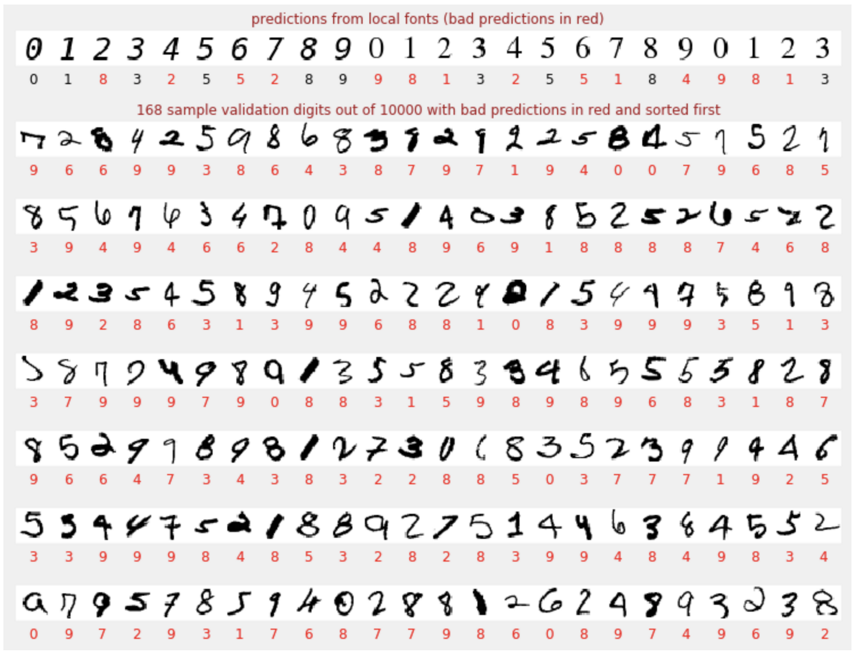

The initial model is not very good but still recognizes some digits correctly. Its final validation accuracy can be around 90%. Not bad for a simplistic model. Yet, still the model misses 1000 validation digits out of the 10,000. That is far more that can be displayed, which is why it looks like all the answers are wrong (red).

In [ ]:
import numpy as np                      # Numpy is used for matrix operations and handling arrays
import pandas as pd                     # Pandas helps us load and manage the dataset easily
from matplotlib import pyplot as plt    # Matplotlib will allow us to visualize the digits and any training progress



**Read in the MNIST Training Dataset from Kaggle**

Each image in the MNIST dataset is a 28x28 pixel grayscale image. The pixel intensities range from 0 (black) to 255 (white). Each image corresponds to a label, which is the digit (0-9) in the image.




In [ ]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

**Prepare data**

1. Convert data to matrices and vectors (i.e. numpy arrays).
2. Extract x,y points. x's are 28 x 28 matrices and y is a digit label 0...9.
3. Normalize x data to be between 0 and 1. Image data is encoded in pixel intensity with values ranging from 0-255. NNs will work best with values that range between 0 and 1.


In [ ]:
# Convert the pandas DataFrame to a NumPy array
data = np.array(data)

# Get the number of rows (m) and columns (n) in the dataset
m, n = data.shape

# Shuffle the data randomly to ensure the training and dev sets are representative
np.random.shuffle(data)

# Create the development (dev) set
# Select the first 1000 rows and transpose the matrix
data_dev = data[0:1000].T

# Extract the labels (Y_dev) from the first column of the dev set
Y_dev = data_dev[0]

# Extract the features (X_dev) from the remaining columns of the dev set
X_dev = data_dev[1:n]

# Normalize the pixel values in the dev set to the range 0-1
X_dev = X_dev / 255.

# Create the training set
# Select rows from index 1000 to the end and transpose the matrix
data_train = data[1000:m].T

# Extract the labels (Y_train) from the first column of the training set
Y_train = data_train[0]

# Extract the features (X_train) from the remaining columns of the training set
X_train = data_train[1:n]

# Normalize the pixel values in the training set to the range 0-1
X_train = X_train / 255.

# Get the shape of the training set features (ignore the first dimension, store the second in m_train)
_,m_train = X_train.shape

In [ ]:
Y_train

array([6, 1, 6, ..., 1, 2, 9])

# NN Architecture

Our NN will have a simple 2-layer architecture (i.e. after the input layer, there i a hidden layer and an output layer).

1. Input layer: $a^{[0]}$ will have 784 units or inputs corresponding to the 784 pixels in each 28x28 input image.
2. Hidden layer $a^{[1]}$ will have 10 units (predictors) with ReLU activation
3. Output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with a softmax activation.


**Forward propagation**
Compute activations at the first layer using ReLU. Those activations are inputs to the output layer. We do one more round of dot products with the weights before applying the final activation to produce an output.




$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$




**Softmax**

As for the last (output) layer, we will use the softmax activation. The softmax is used for multi-class classification and is defined by:

$σ(\mathbf{z})_i=\frac{ e^{z_i} }{ \sum_{j=1}^k e^{z_j} }$

where:
*   $\sigma$ represents the softmax function,
*   $z$ is the input vector.
*   $z_i$ is the i-th element of the input vector.
*   $K$ is the number of classes in the multi-class classifier.
*   $\sigma(z)_i$ is the i-th element of the output vector (the probability of the i-th class).


There is an excellent video, worth studying that will very clearly help you understand how it works. See this link:
https://www.youtube.com/watch?v=ytbYRIN0N4g


The softmax, essentially, maps any number in the real number line and assigns it a height. Ultimately computing the fraction of a given class with the total sum:

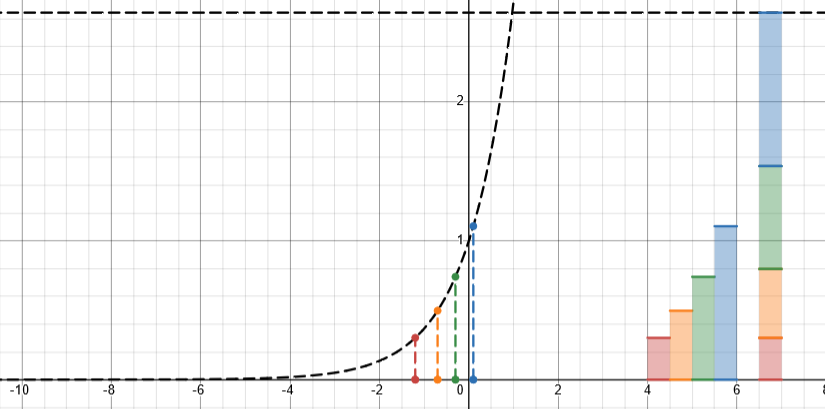

The last layer is then set as:
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

After computing our predictions, we must compute the partial derivatives of the loss with respect to weights (and biases) according to the following equations.



**One-Hot Vector:**
A one-hot encoded vector is a binary vector used to represent categorical data. In this encoding, the vector has a length equal to the number of categories (or classes), with all entries set to 0 except for the position corresponding to the specific category, which is set to 1. This format ensures that each category is represented uniquely while avoiding ordinal relationships between them.


*Example for an MNIST label with 10 classes* (digits 0 to 9):

* If the label corresponds to the digit 3, the one-hot encoded vector would look like this: $[0,0,0,1,0,0,0,0,0,0]$

**Loss Function**

In a multiclass classification problem, the softmax function is used to compute the probabilities for each class. Let $y\in \{0,1\}^C$ be a one-hot encoded target vector, and $\hat{y} \in [0,1]^C$ be the predicted probability vector for C classes. The cross-entropy loss for a single data point is:
$$L=−\sum_{i=1}^C ​y_i  ​log(\hat{y}_i​)$$

where $\hat{y}=softmax(z)$, and $z$ is the vector of raw scores from the model.

**Derivative**

$L_{W,b}(x,y) = A^{[2]} - Y$, where $Y$ is the encoding of labels as one-hot vectors:

$$dZ^{[2]} = A^{[2]} - Y$$




The rest of the derivatives are as follows:

$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter Updates**

Once those derivatives are computed, we can update the weights (And biases) according to the following equations:

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$



**Vars and shapes**
To help you keep track of our different variables, here is a list of our variables and the shapes (dimensions) you should expect:


**Forward prop**

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1



**Backprop**

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

# Functions
Let's start by defining variableas and functions. We will have:

1. init_params(): we will initialize weight matrices and biases
2. ReLU(z): computes the relu activation of the input
3. softmax(z): computes the softmax activation of the input
4. forward_prop(...): computes the forward pass for the 2 layers
5. backward_prop(...): computes the loss and the derivaties wrt params.
6. ReLU_deriv(...): computes the derivative of the relu.
7. one_hot(v): for 10 categories, create a sparse vector for the category to be true.
8. update_params(...): update the weights bbased on step_sz*deriv L.
9. get_predictions(a): returns the argument for the highest logit (or class) probability.
10. get_accuracy(...): returns fraction of correction predictions.
11. gradient_descent(...): optimization algorithm


In [ ]:
def init_params():
  """
  Initializes the parameters (weights and biases) of the neural network.

  Returns:
    W1 (numpy.ndarray): Weights for the first layer (10, 784).
    b1 (numpy.ndarray): Biases for the first layer (10, 1).
    W2 (numpy.ndarray): Weights for the second layer (10, 10).
    b2 (numpy.ndarray): Biases for the second layer (10, 1).
  """
  W1 = np.random.rand(10, 784) - 0.5
  b1 = np.random.rand(10, 1) - 0.5
  W2 = np.random.rand(10, 10) - 0.5
  b2 = np.random.rand(10, 1) - 0.5
  return W1, b1, W2, b2


In [ ]:

def ReLU(Z):
  """
  Applies the Rectified Linear Unit (ReLU) activation function.

  Args:
    Z (numpy.ndarray): Input values.

  Returns:
    numpy.ndarray: Output values after applying ReLU.
  """
  return np.maximum(Z, 0)


In [ ]:
def softmax(Z):
    """
    Applies the softmax activation function.

    Args:
        Z (numpy.ndarray): Input values.

    Returns:
        numpy.ndarray: Output values after applying softmax.
    """
    A = np.exp(Z) / sum(np.exp(Z))
    return A


In [ ]:

def forward_prop(W1, b1, W2, b2, X):
    """
    Performs forward propagation through the neural network.

    Args:
        W1 (numpy.ndarray): Weights for the first layer.
        b1 (numpy.ndarray): Biases for the first layer.
        W2 (numpy.ndarray): Weights for the second layer.
        b2 (numpy.ndarray): Biases for the second layer.
        X (numpy.ndarray): Input data.

    Returns:
        Z1 (numpy.ndarray): Weighted sum of inputs for the first layer.
        A1 (numpy.ndarray): Activations of the first layer.
        Z2 (numpy.ndarray): Weighted sum of inputs for the second layer.
        A2 (numpy.ndarray): Activations of the second layer.
    """
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2


## Derivative Functions

In [ ]:
def ReLU_deriv(Z):
    """
    Calculates the derivative of the ReLU activation function: 1 if Z > 0, 0 otherwise.

    Args:
        Z (numpy.ndarray): Input values.

    Returns:
        numpy.ndarray: Derivative of ReLU for each input value.
    """
    return Z > 0


In [ ]:

def one_hot(Y):
    """
    Converts a vector of labels into a one-hot encoded matrix. one-hot encoded matrices are used for multiclass classification
    and are set as follows:
    - Create a vector of zeros with length equal to the number of categories.
    - Set the element corresponding to the data point's category to 1.

    Args:
        Y (numpy.ndarray): Vector of labels.

    Returns:
        numpy.ndarray: One-hot encoded matrix.
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) # init maxtrix data_points by categories (all set to 0)
    one_hot_Y[np.arange(Y.size), Y] = 1         # create a set of row-col indeces and set those to 1
    one_hot_Y = one_hot_Y.T                     # Transpose rows and cols to give the NN num_of_categories x num_of_data_points

    return one_hot_Y


In [ ]:

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    """
    Performs backpropagation to calculate gradients for updating the network's weights and biases.
    Assumes a mean square error function (not great for classification). See: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..tensorflow-world-2019#3
    for more details on the dross entropy loss.

    Args:
        Z1 (numpy.ndarray): Weighted sum of inputs for the first layer.
        A1 (numpy.ndarray): Activations of the first layer (after applying ReLU).
        Z2 (numpy.ndarray): Weighted sum of inputs for the second layer.
        A2 (numpy.ndarray): Activations of the second layer (after applying softmax).
        W1 (numpy.ndarray): Weights for the first layer.
        W2 (numpy.ndarray): Weights for the second layer.
        X (numpy.ndarray): Input data.
        Y (numpy.ndarray): True labels for the input data.

    Returns:
        dW1 (numpy.ndarray): Gradient of the loss with respect to W1.
        db1 (numpy.ndarray): Gradient of the loss with respect to b1.
        dW2 (numpy.ndarray): Gradient of the loss with respect to W2.
        db2 (numpy.ndarray): Gradient of the loss with respect to b2.
    """
    one_hot_Y = one_hot(Y)                  # Convert true labels to one-hot encoding
    dZ2 = A2 - one_hot_Y                    # Calculate error in output layer (dZ2)

    # 2nd layer: dW2 = (dL / dA2) * (dA2 / dZ2) * (dZ2 / dW2)->simplified to:
    dW2 = 1 / m * dZ2.dot(A1.T)             # Calculate gradient of loss w.r.t. W2
    db2 = 1 / m * np.sum(dZ2)               # Calculate gradient of loss w.r.t. b2

    # 1st layer
    # dZ1 = (dL / dA2) * (dA2 / dZ2) * (dZ2 / dA1) * (dA1 / dZ1)->simplified to:
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)    # Calculate error in hidden layer (dZ1)

    # dW1 = (dL / dA2) * (dA2 / dZ2) * (dZ2 / dA1) * (dA1 / dZ1) * (dZ1 / dW1)->simplified to:
    dW1 = 1 / m * dZ1.dot(X.T)              # Calculate gradient of loss w.r.t. W1
    db1 = 1 / m * np.sum(dZ1)               # Calculate gradient of loss w.r.t. b1

    # Return calculated gradients
    return dW1, db1, dW2, db2


In [ ]:

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    Updates the parameters (weights and biases) of the neural network using gradient descent.

    Args:
        W1 (numpy.ndarray): Weights for the first layer.
        b1 (numpy.ndarray): Biases for the first layer.
        W2 (numpy.ndarray): Weights for the second layer.
        b2 (numpy.ndarray): Biases for the second layer.
        dW1 (numpy.ndarray): Gradient of the loss with respect to W1.
        db1 (numpy.ndarray): Gradient of the loss with respect to b1.
        dW2 (numpy.ndarray): Gradient of the loss with respect to W2.
        db2 (numpy.ndarray): Gradient of the loss with respect to b2.
        alpha (float): Learning rate.

    Returns:
        W1 (numpy.ndarray): Updated weights for the first layer.
        b1 (numpy.ndarray): Updated biases for the first layer.
        W2 (numpy.ndarray): Updated weights for the second layer.
        b2 (numpy.ndarray): Updated biases for the second layer.
    """
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [ ]:
def get_predictions(A2):
    """
    Gets the predicted labels from the output layer activations.

    Args:
        A2 (numpy.ndarray): Activations of the output layer.

    Returns:
        numpy.ndarray: Predicted labels.
    """
    return np.argmax(A2, 0)


In [ ]:
def get_accuracy(predictions, Y):
    """
    Calculates the accuracy of the predictions.

    Args:
        predictions (numpy.ndarray): Predicted labels.
        Y (numpy.ndarray): True labels.

    Returns:
        float: Accuracy.
    """
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


"Training" the neural network actually means using training images and labels to adjust weights and biases so as to minimise the cross-entropy loss function. Here is how it works.

The loss is a function of weights, biases, pixels of the training image and its known class.

If we compute the partial derivatives of the cross-entropy relatively to all the weights and all the biases we obtain a "gradient", computed for a given image, label, and present value of weights and biases. Remember that we can have millions of weights and biases so computing the gradient sounds like a lot of work. The mathematical property of a gradient is that it points "up". Since we want to minimize error, we go in the opposite direction. We update weights and biases by a fraction of the gradient. We then do the same thing again and again using the next batches of training images and labels, in a training loop. Hopefully, this converges to a place where the loss is minimal although nothing guarantees that this minimum is unique.

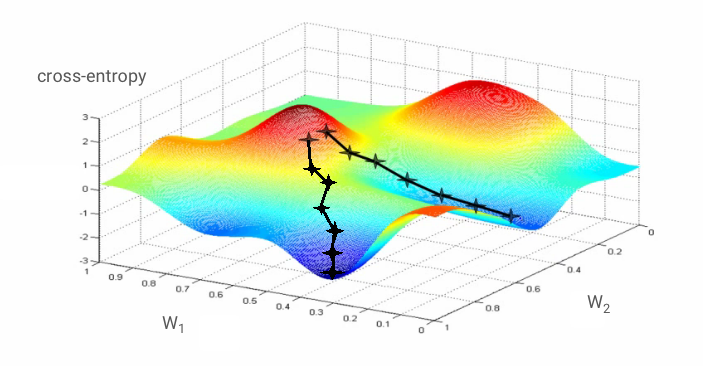


In [ ]:
def gradient_descent(X, Y, alpha, iterations):
    """
    Performs gradient descent to train the neural network.
    There are 3 steps: forward prop, back prop, and update params.

    Args:
        X (numpy.ndarray): Input data.
        Y (numpy.ndarray): True labels.
        alpha (float): Learning rate.
        iterations (int): Number of iterations.

    Returns:
        W1 (numpy.ndarray): Trained weights for the first layer.
        b1 (numpy.ndarray): Trained biases for the first layer.
        W2 (numpy.ndarray): Trained weights for the second layer.
        b2 (numpy.ndarray): Trained biases for the second layer.
    """
    # Initialize weights and biases
    W1, b1, W2, b2 = init_params()

    # Optimize across epochs
    for i in range(iterations):

        # Forward propagation
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)

        # Back propagation
        dW1, db1, dW2, db2 = backward_prop(
            Z1, A1, Z2, A2, W1, W2, X, Y)

        # Optimization
        W1, b1, W2, b2 = update_params(
            W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Compute predictions every 10 epochs.
        # Also, print accuracy of those predictions.
        # Should see predictions improve with more practice.
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))

    return W1, b1, W2, b2

## Training Time:
After defining our functions, we can finally train our network given our training data.

We will input (training) digit images and labels; along with step size, and number of epochs. The function will print performance or accuracy (that is the fraction of sampled digits that the predictor classified correctly).

After training, we will use our parameters (weights and biases) to test with unseen testing data.


In [ ]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[6 8 6 ... 8 6 2] [6 1 6 ... 1 2 9]
0.15770731707317073
Iteration:  10
[6 7 6 ... 3 6 7] [6 1 6 ... 1 2 9]
0.18807317073170732
Iteration:  20
[6 7 6 ... 3 6 9] [6 1 6 ... 1 2 9]
0.24373170731707317
Iteration:  30
[7 2 6 ... 3 6 9] [6 1 6 ... 1 2 9]
0.2881219512195122
Iteration:  40
[7 3 6 ... 3 6 9] [6 1 6 ... 1 2 9]
0.3380487804878049
Iteration:  50
[7 3 6 ... 1 6 9] [6 1 6 ... 1 2 9]
0.4466829268292683
Iteration:  60
[7 1 6 ... 1 6 9] [6 1 6 ... 1 2 9]
0.5129024390243903
Iteration:  70
[7 1 6 ... 1 2 9] [6 1 6 ... 1 2 9]
0.5591951219512196
Iteration:  80
[6 1 6 ... 1 2 9] [6 1 6 ... 1 2 9]
0.5947560975609756
Iteration:  90
[6 1 6 ... 1 2 9] [6 1 6 ... 1 2 9]
0.6215609756097561
Iteration:  100
[6 1 6 ... 1 2 9] [6 1 6 ... 1 2 9]
0.6445365853658537
Iteration:  110
[6 1 6 ... 1 2 9] [6 1 6 ... 1 2 9]
0.662219512195122
Iteration:  120
[6 1 6 ... 1 2 9] [6 1 6 ... 1 2 9]
0.6784634146341464
Iteration:  130
[6 1 6 ... 1 2 9] [6 1 6 ... 1 2 9]
0.6932926829268292
Iteration:  140

## Performance

 From the last line, on iteration 490, we can see that our model predictions achieved an accuracy of **84.5%** on training set.

 Now that we have trained, we will test on unseen data (note, we did not use a validation test here).

# Testing
To test, we will need to define two functions:

1.   make_prediction(): uses trained parameters to make prediction
2.   test_prediction(): calls make_prediction on all test examples and computes performance.

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    """
    Makes predictions on input data X using the trained neural network parameters (weights and biases).
    This function, will typically be called in test_prediction.

    Args:
        X (numpy.ndarray): Input data.
        W1 (numpy.ndarray): Trained weights for the first layer.
        b1 (numpy.ndarray): Trained biases for the first layer.
        W2 (numpy.ndarray): Trained weights for the second layer.
        b2 (numpy.ndarray): Trained biases for the second layer.

    Returns:
        numpy.ndarray: Predicted labels.
    """
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions


Before we begin, let's do a simple test to get comfortable.

We will start by testing on already used training dataset. We will visualize the numbers as well.

In [ ]:
def test_prediction(index, W1, b1, W2, b2):
    """
    Tests a prediction on a specific data point (index) from the training set.

    Args:
        index (int): Index of the data point in the training set.
        W1 (numpy.ndarray): Trained weights for the first layer.
        b1 (numpy.ndarray): Trained biases for the first layer.
        W2 (numpy.ndarray): Trained weights for the second layer.
        b2 (numpy.ndarray): Trained biases for the second layer.

    Returns:
        None
    """
    # Extract a 784 x 1 vector of image at index
    current_image = X_train[:, index, None] # slice all rows, at col index. None ensures the numpy array is not just a  1-dimensional array (784 pixels) but a 2-dimensional array (784, 1)

    # Make prediction for above index.
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)

    # Extract label and print it alongside prediction
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    # Now plot the image to visualize the label
    current_image = current_image.reshape((28, 28)) * 255 # Re-format to be able to display it
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [6]
Label:  6


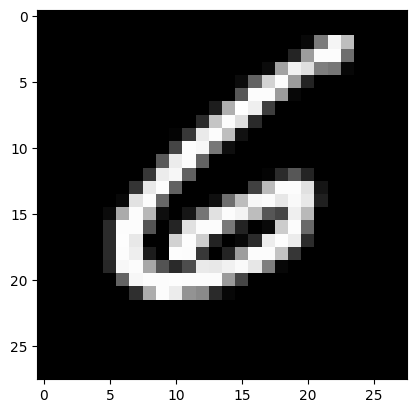

Prediction:  [1]
Label:  1


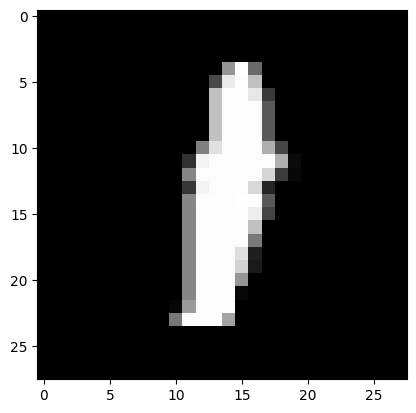

Prediction:  [6]
Label:  6


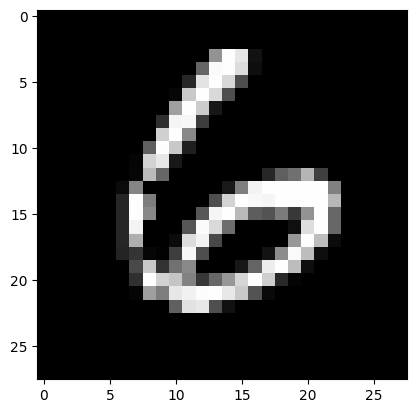

Prediction:  [6]
Label:  6


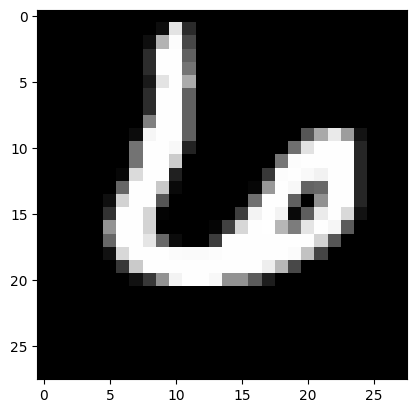

In [ ]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally we will test the performance of the current model on a test data "X_dev" set:



In [ ]:
# Make predictions for test data set. dev_predictions will hold the predicted labels for 1000 digits.
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)

In [ ]:
# Print the fraction of correct predictions.
get_accuracy(dev_predictions, Y_dev)

[1 2 6 3 1 9 5 6 0 6 3 6 0 4 0 1 7 5 3 2 7 9 6 8 0 9 4 2 8 2 2 5 5 5 1 3 4
 2 0 2 1 4 7 3 7 5 4 9 6 6 4 2 5 2 8 8 2 8 1 2 6 6 6 7 0 8 0 3 7 7 4 0 9 4
 6 4 2 9 6 0 6 7 9 1 6 6 6 4 2 1 3 4 4 0 4 4 1 8 2 1 1 7 2 5 8 2 6 5 4 5 0
 6 1 7 9 6 9 6 9 7 1 2 7 9 0 7 1 3 4 3 0 3 3 4 9 9 4 3 8 2 5 0 8 6 3 6 4 5
 9 2 2 6 6 6 9 9 8 0 4 5 0 6 2 5 8 3 9 6 9 2 5 0 2 2 0 6 7 0 1 3 4 6 3 2 3
 3 2 8 4 7 1 1 3 7 2 1 3 3 2 9 0 1 0 0 4 7 3 1 2 1 8 8 8 7 7 7 0 6 8 4 7 2
 3 8 9 3 5 9 0 9 8 1 3 5 9 1 7 9 2 4 7 8 7 6 9 5 6 9 2 6 0 1 8 3 3 9 9 3 6
 0 9 2 8 2 6 5 3 0 5 3 0 7 1 0 6 7 6 5 1 7 3 4 2 7 3 7 2 4 1 4 9 7 2 3 5 0
 2 6 2 7 5 1 5 4 3 0 2 4 1 2 8 8 8 3 0 4 8 7 0 6 5 2 6 6 3 7 9 5 4 8 4 6 6
 5 0 4 0 9 7 1 9 2 6 3 4 7 1 4 2 4 0 8 1 6 6 9 1 2 1 8 5 6 4 4 2 0 7 4 7 5
 0 7 8 0 5 3 8 1 6 1 1 3 6 8 5 8 1 7 2 7 2 7 2 1 0 1 6 9 2 1 6 9 3 9 8 4 5
 1 0 0 0 9 9 1 3 6 2 1 6 0 2 3 2 3 2 8 2 2 8 0 9 7 4 9 3 7 7 1 7 9 5 8 0 0
 8 7 8 1 3 0 4 0 5 9 8 9 3 6 1 6 2 6 7 5 9 5 2 7 0 1 1 8 7 9 6 2 3 2 8 1 4
 4 6 1 6 6 6 3 0 6 2 7 1 

0.839

# Test Results

Our performance on the testing set was 84% accuracy. A somewhat decent number. In indicates the model "generalized" well to unseen cases.





**What to try next?**

You would vary hyperparameters including: step size, number of epochs, SGD, etc.
Can you find a combination that leads to over 90% accuracy in your test data set?